# **Advanced Multimedia Anonymization through Generative Artificial Intelligence**

References:
- Segment Anything Model (SAM):
https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb

- In-painting pipeline for Stable Diffusion using 🧨 Diffusers: https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [2]:
!pip install -qq -U diffusers transformers ftfy accelerate
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.2 MB/s e

#🛑Manual step:
To use private and gated models on 🤗 Hugging Face Hub, login is required. If you are only using a public checkpoint (such as `runwayml/stable-diffusion-inpainting` in this notebook), you can skip this step.

In [3]:
from huggingface_hub import notebook_login

notebook_login()


In [9]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL

from diffusers import StableDiffusionInpaintPipeline
from diffusers import StableDiffusionPipeline

import os

import requests
from io import BytesIO

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [5]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_path,torch_dtype=torch.float16,).to(device)
pipe.safety_checker = None
pipe.requires_safety_checker = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [6]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

#img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
#mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

### Download SAM weights

In [7]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights


In [8]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))


/content/weights/sam_vit_h_4b8939.pth ; exist: True


#🛑Manual step
**Drag-and-drop interface for uploading images**



In [10]:
from ipywidgets import FileUpload, VBox
from IPython.display import display

!mkdir -p {HOME}/data

upload_dir = os.path.expanduser("/content/data")

os.makedirs(upload_dir, exist_ok=True)

uploaded_filenames = []

def handle_upload(change):
    for filename, file_info in change['new'].items():
        file_path = os.path.join(upload_dir, filename)
        with open(file_path, 'wb') as f:
            f.write(file_info['content'])
        uploaded_filenames.append(filename)
        print(f"Saved {filename} to {file_path}")

upload_widget = FileUpload(accept='image/*', multiple=True)
upload_widget.observe(handle_upload, names='value')

display(VBox([upload_widget]))


## Load Model

In [11]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [12]:
mask_generator = SamAutomaticMaskGenerator(sam)

IMAGE_NAME = uploaded_filenames[-1] # Set IMAGE_NAME to the latest image uploaded
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [13]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [14]:
print(sam_result[0].keys())

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

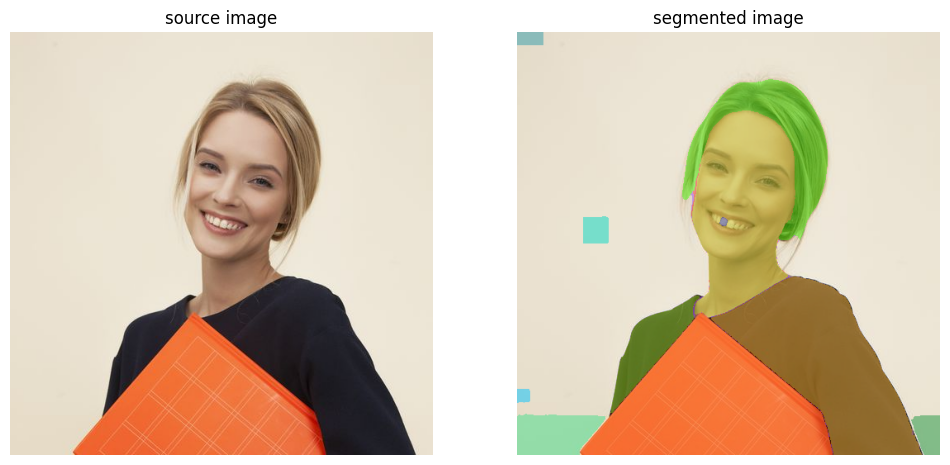

In [15]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'])

### Interaction with segmentation results

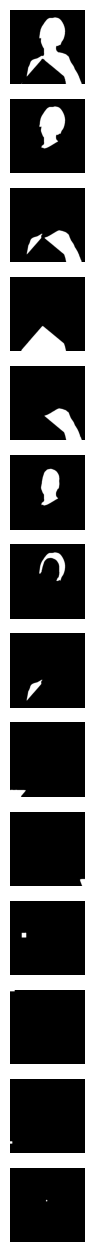

In [16]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(14, int(len(masks) / 8)),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [17]:
mask_predictor = SamPredictor(sam)

In [18]:
IMAGE_NAME = uploaded_filenames[-1] # Set IMAGE_NAME to the latest image uploaded
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [19]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

#🛑Manual step
**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [20]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [21]:
widget.bboxes

[{'x': 192, 'y': 50, 'width': 190, 'height': 301, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [22]:
# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [23]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


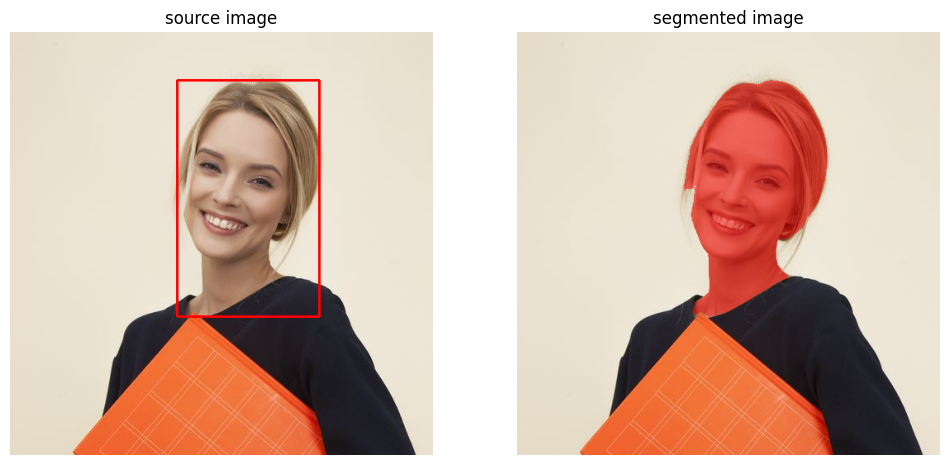

In [24]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

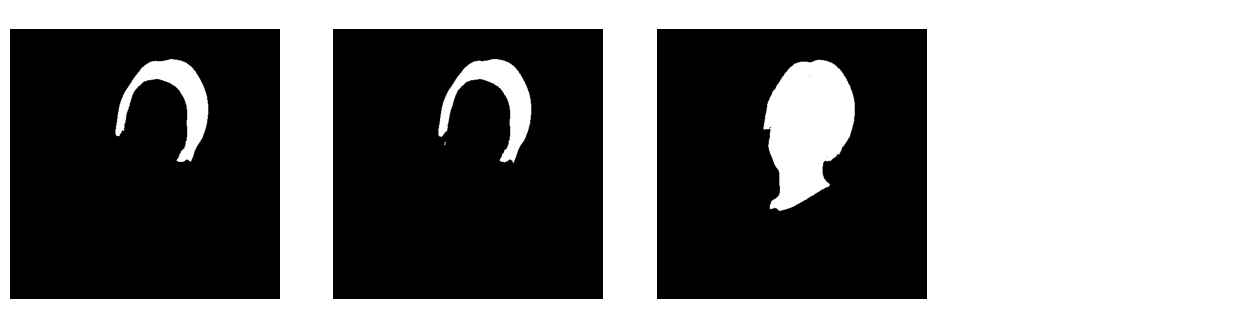

In [25]:
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

## Segment Anything in Roboflow Universe Dataset

### Utils Supporting Dataset Processing

A couple of helper functions that, unfortunately, we have to write ourselves to facilitate the processing of COCO annotations.

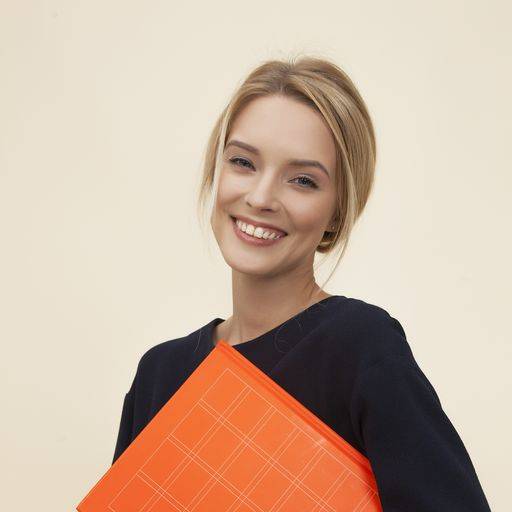

In [26]:
#image
from PIL import Image

# Define the path to your image
image_path = IMAGE_PATH

# Open the image
image = Image.open(image_path)

# Resize the image
image = image.resize((512, 512))

image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
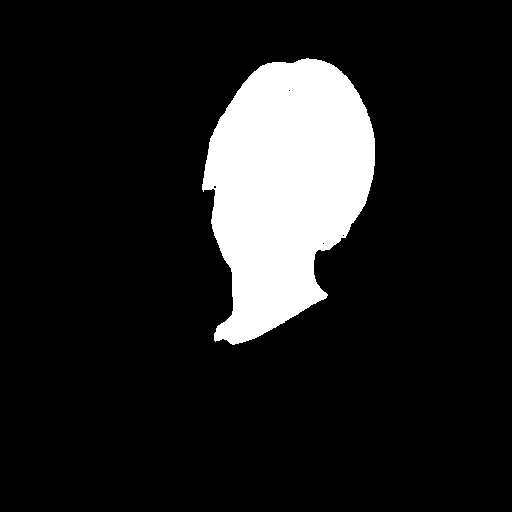

In [27]:
# Assuming masks is a list or array of masks
# Convert each mask to binary format (0 or 1) if they are not already
masks = [(mask * 255).astype(np.uint8) for mask in masks]

# Function to count white pixels in a mask
def count_white_pixels(mask):
    return np.sum(mask == 255)

# Find the mask with the most white pixels
mask_with_most_white_pixels = max(masks, key=count_white_pixels)

# Resize the mask to 512x512
mask_image = cv2.resize(mask_with_most_white_pixels, (512, 512), interpolation=cv2.INTER_NEAREST)

# Display the mask image
mask_image


Expanded mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
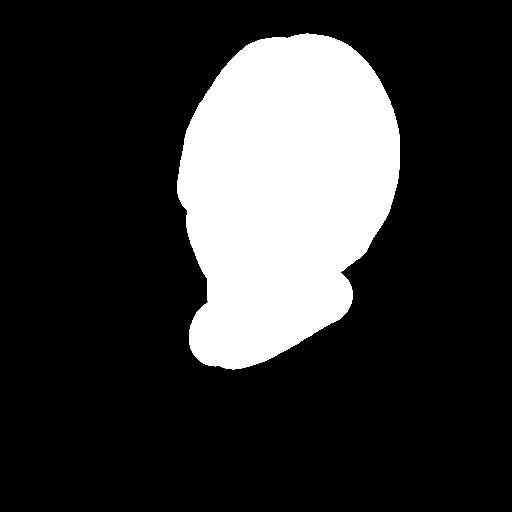

In [28]:
# Calculate 10% of the dimensions of the mask
height, width = mask_image.shape[:2]
kernel_size = int(0.1 * min(height, width))

# Ensure the kernel size is odd to have a center pixel
if kernel_size % 2 == 0:
    kernel_size += 1

# Define the elliptical (circular) kernel for dilation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

# Apply dilation to expand the mask
expanded_mask_image = cv2.dilate(mask_image, kernel, iterations=1)

# Display or save the expanded mask as needed
expanded_mask_image


#🛑Manual step
**Review parameters**

In [30]:
prompt = "the face of a woman, realistic, brown hair, she is young and looking at the camera, friendly, pretty and natural, (her mouth is closed)++"
negative_prompt="glasses, anime, cartoon, make-up, teeth"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(145) # change the seed to get different results
num_interference_steps = 100
strength = 0.8

images = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=image,
    mask_image=expanded_mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
    num_interference_steps = num_interference_steps,
    strength=strength,
).images


  0%|          | 0/40 [00:00<?, ?it/s]

In [31]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

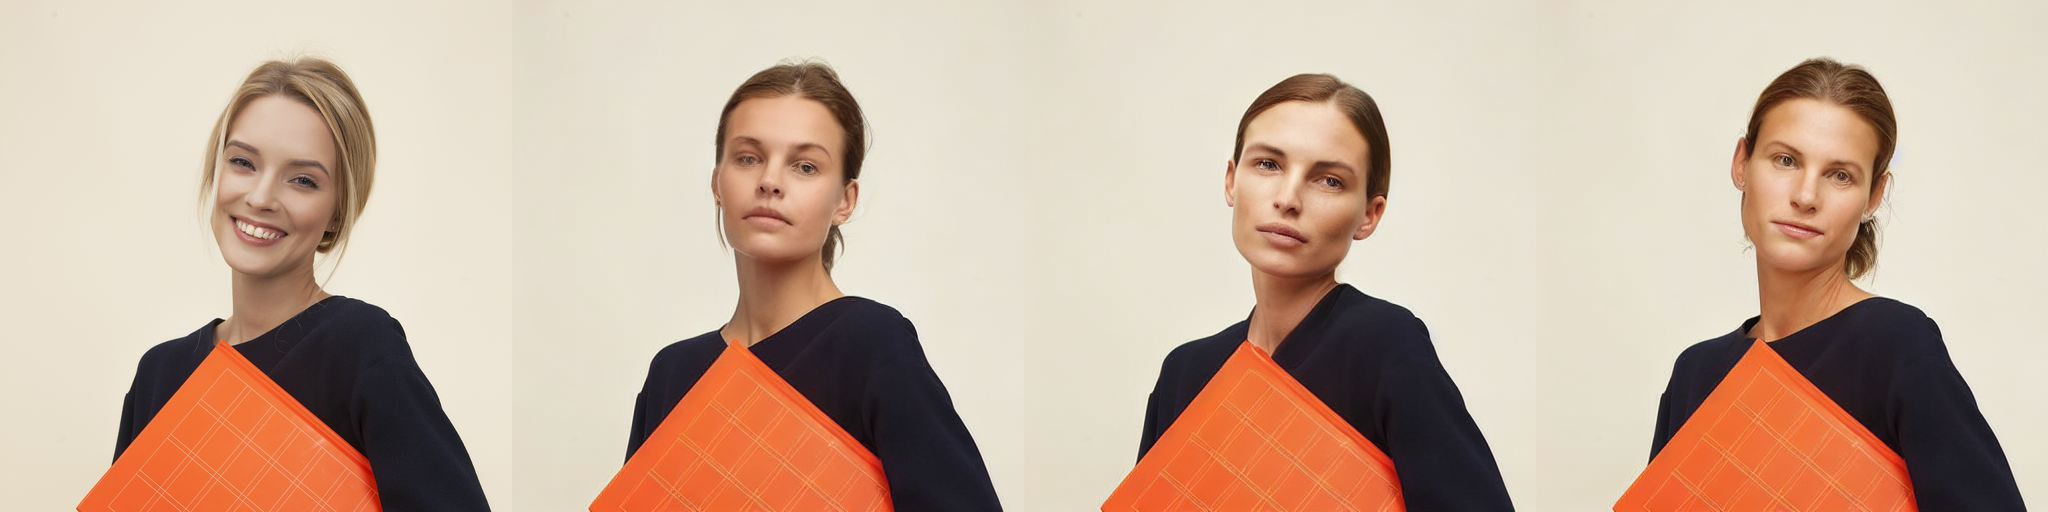

In [32]:
image_grid(images, 1, num_samples + 1)


OPTIONAL: creates comparative table with mask

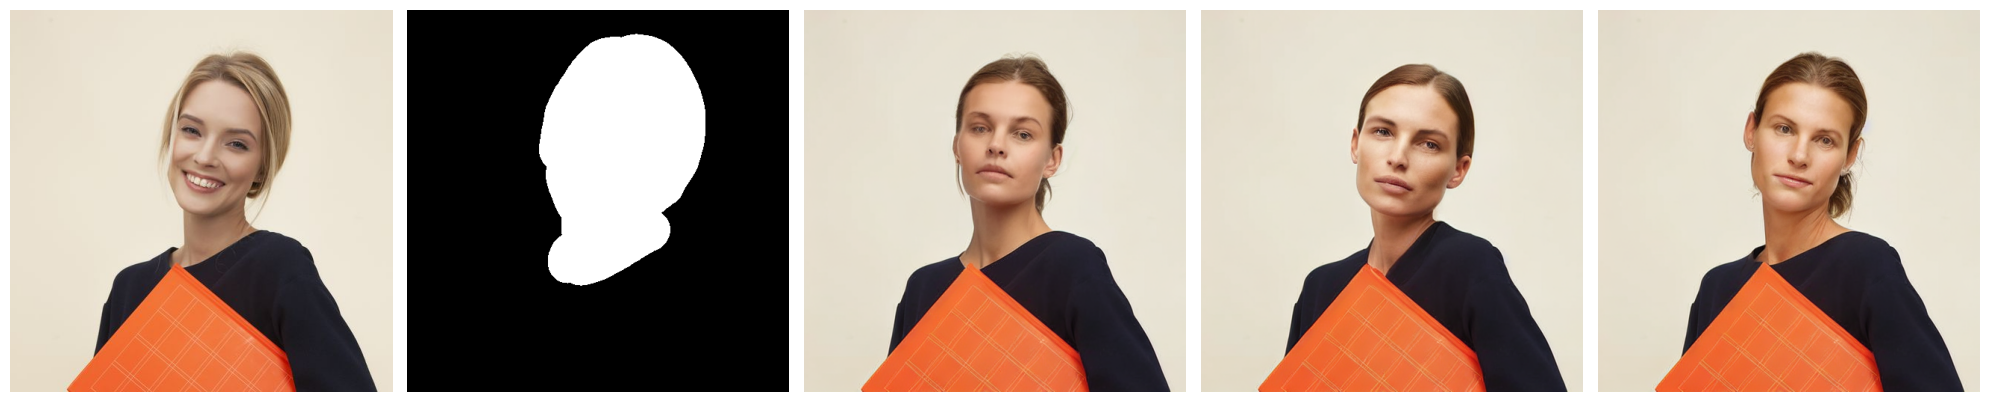

In [33]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

# Titles for the images, including the mask image in the correct order
titles = ["Original", "Expanded Mask", "Sample 1", "Sample 2", "Sample 3"]

# Convert images to format suitable for matplotlib
images = [Image.fromarray(np.array(img)) for img in images]
images.insert(1, expanded_mask_image)  # Add the mask image to the second position

# Create the image grid with titles using matplotlib
def create_titled_image_grid(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    if num_images == 1:
        axes = [axes]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray' if title == "Expanded Mask" else None)  # Ensure mask is shown in grayscale
       # ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display the titled image grid
create_titled_image_grid(images, titles)


OPTIONAL: Download images

In [34]:
# Save the images, excluding the mask
for idx, (img, title) in enumerate(zip(images, titles)):
    if title != "Expanded Mask":
        img = img.convert("RGB")  # Ensure image is in RGB mode
        img.save(f"generated_image_{idx}.png")